### This Notebook matches the curves-of-growth of a saturated spot in a JWST image and that of the JWST PSF

The output of this Notebook includes a figure showing the comparison of cutout of saturated spot and PSF, and a json file containing the correction factor.

Then the json file can be used by the Notebook "analyze_ngc1365_fix_saturated_pixels.ipynb" to apply the correction to the real data.

Daizhong Liu (dzliu@mpe.mpg.de; astro.dzliu@gmail.com)


In [1]:
import os, sys, re, copy, glob, shutil, json
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.wcs import WCS, FITSFixedWarning
from astropy.wcs.utils import proj_plane_pixel_area, proj_plane_pixel_scales
from astropy.wcs.utils import wcs_to_celestial_frame
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord, FK5, ICRS
from astropy.units import Quantity
from collections import OrderedDict
from matplotlib import ticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from reproject import reproject_interp
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FITSFixedWarning)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True


In [2]:
# Read obs data

sci_files = OrderedDict()
sci_images = OrderedDict()
sci_headers = OrderedDict()
sci_posangles = OrderedDict()
rms_files = OrderedDict()
rms_images = OrderedDict()
rms_headers = OrderedDict()
for filter_name in ['F200W', 'F300M', 'F335M', 'F360M']:
    key = 'NIRCam ' + filter_name
    sci_files[key] = \
        '/Users/dzliu/Data/PHANGS-JWST/jwst_reprocessed/NIRCam_v0p4p2/ngc1365_nircam_lv3_{}_i2d_align.fits'.format(
            filter_name.lower()
        )
    sci_images[key], sci_headers[key] = fits.getdata(
        sci_files[key], extname='SCI', 
        header=True
    )
    sci_posangles[key] = sci_headers[key]['PA_V3']
    print('{} position angle: {}'.format(key, sci_posangles[key]))
    
    rms_files[key] = sci_files[key]
    rms_images[key], rms_headers[key] = fits.getdata(
        rms_files[key], extname='ERR', 
        header=True
    )

for filter_name in ['F770W', 'F1000W', 'F1130W', 'F2100W']:
    key = 'MIRI ' + filter_name
    sci_files[key] = \
        '/Users/dzliu/Data/PHANGS-JWST/jwst_reprocessed/MIRI_v0p5/ngc1365_miri_{}_anchored.fits'.format(
            filter_name.lower()
        )
    sci_images[key], sci_headers[key] = fits.getdata(
        sci_files[key], 
        header=True
    )
    sci_posangles[key] = sci_headers['NIRCam F200W']['PA_V3'] + 4.45 
    print('{} position angle: {}'.format(key, sci_posangles[key]))
    # https://jwst-docs.stsci.edu/jwst-observatory-characteristics/jwst-position-angles-ranges-and-offsets
    # MIRI is rorated by 4.45 deg counterclosewise from V3 PA.
    
    rms_files[key] = sci_files[key].replace('_anchored.fits', '_noisemap.fits')
    rms_images[key], rms_headers[key] = fits.getdata(
        rms_files[key], 
        header=True
    )


# Define astrometry correction / WCS shifts for some images (using F200W as reference)

wcs_shifts = OrderedDict()
wcs_shifts['NIRCam F300M'] = (0.0 * u.arcsec, -0.015 * u.arcsec)
wcs_shifts['NIRCam F335M'] = (0.0 * u.arcsec, -0.015 * u.arcsec)
wcs_shifts['NIRCam F360M'] = (0.0 * u.arcsec, -0.015 * u.arcsec)
wcs_shifts['MIRI F770W'] = (0.16 * u.arcsec, -0.11 * u.arcsec) # the direction one wants to move the image (+ to the right/up)
wcs_shifts['MIRI F1000W'] = wcs_shifts['MIRI F770W']
wcs_shifts['MIRI F1130W'] = (0.05 * u.arcsec, -0.06 * u.arcsec)
wcs_shifts['MIRI F2100W'] = wcs_shifts['MIRI F1130W']


# Apply astrometry correction

for key in sci_images: 
    if key in wcs_shifts:
        dRA, dDec = wcs_shifts[key]
        sci_header = sci_headers[key]
        sci_wcs = WCS(sci_header, naxis=2)
        sci_frame = wcs_to_celestial_frame(sci_wcs)
        ra, dec = sci_header['CRVAL1'], sci_header['CRVAL2']
        sci_header['CRVAL1'] -= dRA.to(u.deg).value / np.cos(np.deg2rad(dec))
        sci_header['CRVAL2'] += dDec.to(u.deg).value
        print('{}, applying astrometry correction wcs shift {} {}'.format(key, dRA, dDec))
        sci_headers[key] = sci_header


# Define photometric correction / bkg levels for some images
# bkg_levels = OrderedDict()
# bkg_levels['NIRCam F200W'] = 65.
# bkg_levels['NIRCam F300M'] = 40
# bkg_levels['NIRCam F335M'] = 40.
# bkg_levels['NIRCam F360M'] = 40.
# bkg_levels['MIRI F770W'] = 100.
# bkg_levels['MIRI F1000W'] = 90.
# bkg_levels['MIRI F1130W'] = 200.
# bkg_levels['MIRI F2100W'] = 200.


NIRCam F200W position angle: 261.1078648908976
NIRCam F300M position angle: 261.1090399455477
NIRCam F335M position angle: 261.1089846394891
NIRCam F360M position angle: 261.0893218163628
MIRI F770W position angle: 265.5578648908976
MIRI F1000W position angle: 265.5578648908976
MIRI F1130W position angle: 265.5578648908976
MIRI F2100W position angle: 265.5578648908976
NIRCam F300M, applying astrometry correction wcs shift 0.0 arcsec -0.015 arcsec
NIRCam F335M, applying astrometry correction wcs shift 0.0 arcsec -0.015 arcsec
NIRCam F360M, applying astrometry correction wcs shift 0.0 arcsec -0.015 arcsec
MIRI F770W, applying astrometry correction wcs shift 0.16 arcsec -0.11 arcsec
MIRI F1000W, applying astrometry correction wcs shift 0.16 arcsec -0.11 arcsec
MIRI F1130W, applying astrometry correction wcs shift 0.05 arcsec -0.06 arcsec
MIRI F2100W, applying astrometry correction wcs shift 0.05 arcsec -0.06 arcsec


In [3]:
# Read PSF data

psf_files = OrderedDict()
psf_images = OrderedDict()
psf_headers = OrderedDict()
psf_pixelscales = OrderedDict()
psf_oversamples = OrderedDict()
psf_saturatedmasks = OrderedDict()
for key in sci_images:
    instrument_filter_str = key.replace(' ','_')
    #psf_files[key] = '/Users/dzliu/Data/JWST-WebbPSF/webbpsf_{}_oversamp10.fits'.format(instrument_filter_str)
    psf_files[key] = '/Users/dzliu/Data/JWST-WebbPSF/webbpsf_{}_fov20as_oversamp10.fits'.format(instrument_filter_str)
    psf_images[key], psf_headers[key] = fits.getdata(
        psf_files[key], 
        header=True
    )
for key in sci_images:
    psf_saturatedmasks[key] = None
    psf_pixelscales[key] = psf_headers[key]['PIXELSCL']
    psf_oversamples[key] = psf_headers[key]['OVERSAMP'] # the psf was made with this oversample using webbpsf
    print(key, 'pixelscale: {}'.format(psf_pixelscales[key]))

# customizing values
#psf_saturatedmasks['NIRCam F200W'] = 0.12 * u.arcsec
#psf_saturatedmasks['NIRCam F200W'] = None


NIRCam F200W pixelscale: 0.00311
NIRCam F300M pixelscale: 0.0063
NIRCam F335M pixelscale: 0.0063
NIRCam F360M pixelscale: 0.0063
MIRI F770W pixelscale: 0.01108
MIRI F1000W pixelscale: 0.01108
MIRI F1130W pixelscale: 0.01108
MIRI F2100W pixelscale: 0.01108


In [4]:
# Define a star to look at

#star_ra_dec = '3:33:35.9545 -36:09:37.067' # star 1 seen in NIRCam, identified in DS9 under FK5 frame
                                           # 53.39981042, -36.16029639

#star_ra_dec = '3:33:31.2075 -36:08:12.024' # star 2 seen in NIRCam, identified in DS9 under FK5 frame
                                           # 53.38003125, -36.13667333

#star_ra_dec = '3:33:36.3700 -36:08:25.501' # galaxy center, saturated, identified in DS9 under FK5 frame
                                           # 53.40154167, -36.14041694

#star_ra_dec = '3:33:36.6115 -36:08:15.508' # MIRI saturated point, identified in DS9 under FK5 frame
                                           # 53.40254792, -36.13764111

#star_ra_dec = '3:33:36.7708 -36:08:18.590' # MIRI saturated point, identified in DS9 under FK5 frame
                                           # 53.40321167, -36.13849722 # 53.4032325, -36.13847278

star_ra_dec = '3:33:36.4066 -36:08:18.262' # MIRI saturated point, identified in DS9 under FK5 frame
                                           # 53.40169417, -36.13840611



star_skycoord0 = SkyCoord(star_ra_dec, unit=(u.hour, u.deg), frame=FK5, equinox='J2000') # DS9 default is FK5
print('star_skycoord0', star_skycoord0)
print('star_skycoord0.transform_to(ICRS)', star_skycoord0.transform_to(ICRS))
print('star_skycoord0.transform_to(FK5)', star_skycoord0.transform_to(FK5))

# Set star skycoords with shifts corrected

star_skycoords = OrderedDict()
for key in sci_images: 
    scoord = copy.deepcopy(star_skycoord0)
    # if key in wcs_shifts:
    #     star_skycoords[key] = SkyCoord(scoord.transform_to(ICRS).ra + wcs_shifts[key][0], 
    #                                    scoord.transform_to(ICRS).dec - wcs_shifts[key][1], 
    #                                    frame=ICRS)
    #     print('{}, applying WCS shift {} {}, star skycoord {} -> {}'.format(
    #             key, wcs_shifts[key][0], wcs_shifts[key][1], 
    #             star_skycoord0.transform_to(ICRS).to_string('hmsdms', sep=':', precision=5), 
    #             star_skycoords[key].transform_to(ICRS).to_string('hmsdms', sep=':', precision=5), 
    #         ))
    # else:
    #     star_skycoords[key] = scoord


# Define cutout size to look at

cutout_sizes = OrderedDict()
for key in sci_images:
    if key.find('NIRCam')>=0:
        cutout_sizes[key] = 1.75 * u.arcsec
    elif key.find('MIRI')>=0:
        cutout_sizes[key] = 3.50 * u.arcsec
    else:
        raise Exception('The key needs to be NIRCam or MIRI for a cutout_size!')

# customizing values
#cutout_sizes['NIRCam F200W'] = 1.5 * u.arcsec


star_skycoord0 <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (53.40169417, -36.13840611)>
star_skycoord0.transform_to(ICRS) <SkyCoord (ICRS): (ra, dec) in deg
    (53.40169169, -36.13840318)>
star_skycoord0.transform_to(FK5) <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (53.40169417, -36.13840611)>


In [5]:
# Define function to get image position angle from FITS header

def get_position_angle(fits_header):
    rotation_PA = np.nan
    if 'PA_V3' in fits_header:
        rotation_PA = fits_header['PA_V3']
    return rotation_PA

# Define function to get oversampling factor from FITS header

def get_oversampling_factor(fits_header, raise_exception = True):
    oversampling_factor = np.nan
    if 'OVERSAMP' in fits_header:
        oversampling_factor = fits_header['OVERSAMP']
    elif raise_exception:
        raise Exception('Error! \'OVERSAMP\' is not defined in the FITS header!')
    return oversampling_factor

# Define function to get image pixel scale from FITS header or WCS

def get_pixel_scale(input_object):
    if isinstance(input_object, fits.Header):
        this_wcs = WCS(input_object, naxis=2)
    elif isinstance(input_object, WCS):
        this_wcs = input_object
    elif isinstance(input_object, Cutout2D):
        if hasattr(input_object, 'wcs'):
            this_wcs = input_object.wcs
        else:
            this_wcs = WCS(input_object.header, naxis=2)
    else:
        raise Exception('Error! Cannot run get_pixel_scale for the input object type {}'.format(type(input_object)))
    this_pixel_scale = np.sqrt(proj_plane_pixel_area(this_wcs))*u.deg
    return this_pixel_scale

# Define function to get image center RA Dec

def get_center_ra_dec(image, wcs=None):
    if isinstance(image, Cutout2D):
        ny, nx = image.data.shape
        if wcs is None:
            wcs = image.wcs
    elif isinstance(image, fits.Header):
        ny, nx = image['NAXIS2'], image['NAXIS1']
        if wcs is None:
            wcs = WCS(image, naxis=2)
    else:
        ny, nx = image.shape
    ra, dec = wcs.wcs_pix2world([(nx+1.0)/2.0], [(ny+1.0)/2.0], 1)
    ra, dec = ra[0], dec[0]
    return ra, dec


In [6]:
# Define function to make a cutout

def make_cutout(image, wcs:WCS, scoord:SkyCoord, cutsize:Quantity):
    cutout = Cutout2D(data=image, position=scoord, size=cutsize, wcs=wcs, mode='partial')
    return cutout


In [7]:
# Define function to oversample a cutout

def oversample_cutout(cutout, oversample = 10., shift_x = 0.0, shift_y = 0.0, center:SkyCoord = None):
    cutout_header = cutout.wcs.to_header()
    in_header = copy.deepcopy(cutout_header)
    out_header = copy.deepcopy(cutout_header)
    in_ny, in_nx = cutout.data.shape
    in_header['NAXIS1'] = in_nx
    in_header['NAXIS2'] = in_ny
    in_wcs = WCS(in_header, naxis=2)
    in_frame = wcs_to_celestial_frame(in_wcs)
    if center is None:
        # if user has not provided a center SkyCoord, we take the image center as the reference pixel.
        ra, dec = in_wcs.wcs_pix2world([(in_nx+1.)/2.], [(in_ny+1.)/2.], 1)
        ra, dec = ra[0], dec[0]
    else:
        center_transformed = center.transform_to(in_frame)
        ra = center_transformed.ra.deg
        dec = center_transformed.dec.deg
    # 
    # setting reference pixel for later resampling with reproject_interp
    in_header['CRPIX1'] = (in_nx+1.)/2.
    in_header['CRPIX2'] = (in_ny+1.)/2.
    in_header['CRVAL1'] = ra
    in_header['CRVAL2'] = dec
    in_wcs = WCS(in_header, naxis=2)
    # 
    # setting output image dimension and pixel scale
    out_nx = int(np.ceil(in_nx*oversample))
    out_ny = int(np.ceil(in_ny*oversample))
    out_header['NAXIS1'] = out_nx
    out_header['NAXIS2'] = out_ny
    if 'CDELT1' in out_header:
        out_header['CDELT1'] /= oversample
    if 'CDELT2' in out_header:
        out_header['CDELT2'] /= oversample
    if 'CD1_1' in out_header:
        out_header['CD1_1'] /= oversample
    if 'CD1_2' in out_header:
        out_header['CD1_2'] /= oversample
    if 'CD2_1' in out_header:
        out_header['CD2_1'] /= oversample
    if 'CD2_2' in out_header:
        out_header['CD2_2'] /= oversample
    # 
    # setting output reference pixel the image center, 
    # allowing user to input a shift_x, shift_y for the reference pixel to adjust the WCS misalignment manually
    out_header['CRPIX1'] = (out_nx+1.)/2. + shift_x * oversample
    out_header['CRPIX2'] = (out_ny+1.)/2. + shift_y * oversample
    out_header['CRVAL1'] = ra
    out_header['CRVAL2'] = dec
    # 
    # build the output WCS
    out_wcs = WCS(out_header, naxis=2)
    # 
    # do the resampling with reproject_interp
    in_data = cutout.data
    resampled_data = reproject_interp( 
        (in_data, in_wcs), 
        out_wcs, 
        shape_out = (out_ny, out_nx), 
        return_footprint = False,
    )
    # 
    # resetting the output reference pixel to image center
    # this has no effect if user has not input a shift_x, shift_y
    out_header['CRPIX1'] = (out_nx+1.)/2.
    out_header['CRPIX2'] = (out_ny+1.)/2.
    out_wcs = WCS(out_header, naxis=2)
    # 
    # make the output a Cutout2D object
    resampled_cutout = Cutout2D(
        resampled_data, 
        SkyCoord(ra, dec, unit=(u.deg, u.deg), frame=in_frame), 
        (out_ny, out_nx), 
        wcs = out_wcs, 
        mode = 'partial',
    )
    # 
    # return
    return resampled_cutout


In [8]:
# Define function to add a mock WCS to the PSF data

def add_mock_wcs_to_psf(
        psf_image, 
        psf_header, 
        center_ra_dec:SkyCoord, 
        pixel_scale:Quantity, 
        cutout_size:Quantity = None, 
        position_angle:float = None, 
    ):
    """
    Add mock WCS to an PSF image.
    
    Output: 
        A Cutout2D object if cutout_size is provided, otherwise a tuple of (psf_image, psf_header, psf_wcs).
    """
    # 
    # get image dimension
    psf_ny, psf_nx = psf_image.data.shape
    # 
    # check center ra dec
    center_ra_dec_transformed = center_ra_dec.transform_to(ICRS)
    ra = center_ra_dec_transformed.ra.deg
    dec = center_ra_dec_transformed.dec.deg
    # 
    # add mock WCS info PSF header
    psf_header['WCSAXES'] = 2
    #psf_header['RADESYS'] = 'FK5' # DS9 default
    #psf_header['EQUINOX'] = 2000.0
    psf_header['RADESYS'] = 'ICRS' # JWST default
    psf_header['CTYPE1'] = 'RA---TAN'
    psf_header['CTYPE2'] = 'DEC--TAN'
    psf_header['CUNIT1'] = 'deg'
    psf_header['CUNIT2'] = 'deg'
    psf_header['CRVAL1'] = ra
    psf_header['CRVAL2'] = dec
    psf_header['CRPIX1'] = (float(psf_nx)+1.0)/2.0
    psf_header['CRPIX2'] = (float(psf_ny)+1.0)/2.0
    # 
    # set pixel scale
    pixscasec = pixel_scale.to(u.arcsec).value
    pixscdeg = pixel_scale.to(u.deg).value
    for k in ['CDELT1', 'CDELT2', 'CROTA2', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2']:
        if k in psf_header:
            del psf_header[k]
    if position_angle is not None:
        if np.isnan(position_angle):
            print('add_mock_wcs_to_psf(): Warning! The input position angle is NaN!')
            position_angle = None
    if position_angle is not None:
        # wcs88.pdf
        # psf_header['CD1_1'] = -pixscdeg * np.cos(np.deg2rad(position_angle))
        # psf_header['CD1_2'] = -pixscdeg * np.sin(np.deg2rad(position_angle))
        # psf_header['CD2_1'] = -pixscdeg * np.sin(np.deg2rad(position_angle))
        # psf_header['CD2_2'] = pixscdeg * np.cos(np.deg2rad(position_angle))
        psf_header['CDELT1'] = -pixscdeg
        psf_header['CDELT2'] = pixscdeg
        psf_header['CROTA2'] = -position_angle
    else:
        psf_header['CDELT1'] = -pixscdeg
        psf_header['CDELT2'] = pixscdeg
    # 
    # build WCS
    psf_wcs = WCS(psf_header, naxis=2)
    #print('checking psf center:', get_center_ra_dec(psf_header), 'star', (ra, dec))
    # 
    # check cutout size and do cutout
    if cutout_size is not None:
        # 
        # get cutout size from user input
        if isinstance(cutout_size, Quantity):
            cut_asec = cutout_size.to(u.arcsec).value
            out_nx = int(np.ceil(cut_asec/pixscasec))
            out_ny = int(np.ceil(cut_asec/pixscasec))
        else:
            out_nx = int(np.ceil(cutout_size/pixscasec))
            out_ny = int(np.ceil(cutout_size/pixscasec))
        # 
        # do cutout
        psf_image_cutout = Cutout2D(
            psf_image, 
            center_ra_dec_transformed, 
            (out_ny, out_nx), 
            wcs = psf_wcs, 
            mode = 'partial',
        )
        #print('checking psf cutout shape:', psf_image_cutout.data.shape, 'sci shape', sci_image_resampled.data.shape)
        #print('checking psf cutout center:', get_center_ra_dec(psf_image_cutout), 'star', (ra, dec))
        # Note: Cutout2D cuts no fractional pixels, so the output image center will not be exactly (ra, dec)
        # 
        # return
        return psf_image_cutout
    else:
        # 
        # return
        return psf_image, psf_header, psf_wcs


In [9]:
# Define function to match obs and PSF data

def match_obs_and_psf(
        sci_image, 
        sci_header, 
        psf_image, 
        psf_header, 
        star_skycoord:SkyCoord, 
        cutout_size:Quantity, 
        sci_position_angle = None,
    ):
    
    # get psf oversampling factor
    psf_oversample = get_oversampling_factor(psf_header)
    
    # get WCS and celestial frame
    sci_wcs = WCS(sci_header, naxis=2)
    sci_frame = wcs_to_celestial_frame(sci_wcs)
    
    # convert star skycoord to data celestial frame
    star_skycoord_transformed = star_skycoord.transform_to(sci_frame)
    ra = star_skycoord_transformed.ra.deg
    dec = star_skycoord_transformed.dec.deg
    
    # print message
    print('matching obs and psf at star skycoord {} under {} frame'.format(
        star_skycoord_transformed.to_string('hmsdms', sep=':', precision=4), 
        sci_frame))
    
    # make cutout for the sci data
    sci_image_cutout = make_cutout(
        image = sci_image, 
        wcs = sci_wcs, 
        scoord = star_skycoord_transformed,
        cutsize = cutout_size, 
    )
    #print('checking cutout center:', get_center_ra_dec(sci_image_cutout))
    #print('checking cutout bbox:', sci_image_cutout.bbox_original)
    
    # oversample the sci data to match the psf oversampling factor and pixel scale
    sci_image_resampled = oversample_cutout(
        sci_image_cutout, 
        oversample = psf_oversample,
        center = star_skycoord_transformed, 
    )
    
    # get sci position angle
    if sci_position_angle is None:
        sci_position_angle = get_position_angle(sci_header)
    
    # add wcs to the psf data and cutout to the specified size
    psf_image_cutout = add_mock_wcs_to_psf(
        psf_image, 
        psf_header, 
        center_ra_dec = star_skycoord, 
        pixel_scale = get_pixel_scale(sci_image_resampled),
        cutout_size = cutout_size * 1.25, # make it slightly larger for later reproject/cutout
        position_angle = sci_position_angle,
    )
    
    # resample psf cutout to the sci resampled image dimension 
    psf_image_resampled_data = reproject_interp(
        (psf_image_cutout.data, psf_image_cutout.wcs), 
        sci_image_resampled.wcs, 
        sci_image_resampled.data.shape,
        return_footprint = False,
    )
    
    # make the output a Cutout2D object
    psf_image_resampled = Cutout2D(
        psf_image_resampled_data, 
        star_skycoord_transformed, 
        sci_image_resampled.data.shape, 
        wcs = sci_image_resampled.wcs, 
        mode = 'partial',
    )
    
    # print message
    print('matched obs and psf data pixel scales: {:.6f}, {:.6f}; dimensions: {}, {}'.format( 
            get_pixel_scale(sci_image_resampled).to(u.arcsec).value, 
            get_pixel_scale(psf_image_resampled).to(u.arcsec).value,
            sci_image_resampled.shape, 
            psf_image_resampled.shape, 
        ))
    
    # 
    return sci_image_resampled, psf_image_resampled


In [10]:
# Define function to make a comparison plot of two images

def make_plot(input1, input2, pixelsize, fovsize, fig, axes, 
              vmin=None, vmax=None, 
              label1=None, label2=None, 
              scalemode='log', 
              scalebar=1.0, # in arcsec
              scalebar_color='w', 
    ):
    
    # The two images must have the same shape
    
    if isinstance(input1, Cutout2D):
        image1 = input1.data
    else:
        image1 = input1
    if isinstance(input2, Cutout2D):
        image2 = input2.data
    else:
        image2 = input2
    
    if isinstance(pixelsize, Quantity):
        pixelsize = pixelsize.to(u.arcsec).value
    
    if isinstance(fovsize, Quantity):
        fovsize = fovsize.to(u.arcsec).value
    
    if vmin is None:
        #vmin = min(np.nanpercentile(image1, 0.1), np.nanpercentile(image2, 0.1))
        vmin = np.nanpercentile(image1, 0.1) # only use image1
    if vmax is None:
        #vmax = max(np.nanpercentile(image1, 99.9), np.nanpercentile(image2, 99.9))
        vmax = np.nanpercentile(image1, 99.9) # only use image1
    
    norm1 = simple_norm(image1, scalemode, min_cut=vmin, max_cut=vmax)
    norm2 = simple_norm(image2, scalemode, min_cut=vmin, max_cut=vmax)
    maxdiff = np.nanpercentile(np.abs(image1-image2), 95.)
    norm3 = simple_norm(image1-image2, 'linear', min_cut=-maxdiff, max_cut=maxdiff)
    maxratio = 5.0
    ratio = np.log10(image1/image2)
    #norm4 = simple_norm(image1/image2, 'log', min_cut=1./maxratio, max_cut=maxratio)
    norm4 = simple_norm(ratio, 'linear', min_cut=np.log10(1./maxratio), max_cut=np.log10(maxratio))
    
    if label1 is None:
        label1 = 'image1'
    if label2 is None:
        label2 = 'image2'
    
    for iax, ax, data, norm, cmap, title in zip(
            np.arange(len(axes)), 
            axes, 
            [image1, image2, image1-image2, ratio],
            [norm1, norm2, norm3, norm4],
            ['viridis', 'viridis', 'bwr', 'bwr'], 
            [label1, label2, 
             label1.split()[-1] + ' $-$ ' + label2.split()[-1], 
             'log10(' + label1.split()[-1] + ' $/$ ' + label2.split()[-1] + ')']
        ):
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', size='7%', pad='2%')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        ny, nx = data.shape
        extent = [-0.5*nx*pixelsize, 0.5*nx*pixelsize, -0.5*ny*pixelsize, 0.5*ny*pixelsize]
        im = ax.imshow(data, origin='lower', interpolation='nearest', extent=extent, norm=norm, cmap=cmap)
        ax.set_xlim([-0.5*fovsize, 0.5*fovsize])
        ax.set_ylim([-0.5*fovsize, 0.5*fovsize])
        cbar = fig.colorbar(im, cax=cax)
        #if iax == len(axes)-1:
        #    cax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        #    cax.yaxis.set_major_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.5,)))
        
        # plot a cross at the image center
        ax.plot([0.0], [0.0], marker='+', color='k', alpha=0.8, markersize=10)
        
        # plot a scale bar at lower left
        if iax == 0:
            # ax.plot([-0.475*fovsize, -0.475*fovsize + scalebar], 
            #         [-0.475*fovsize, -0.475*fovsize], 
            #         color=scalebar_color, lw=0.75, alpha=0.9)
            # ax.text(-0.475*fovsize + 0.5*scalebar, 
            #         -0.475*fovsize, 
            #         "${}''$".format(scalebar), 
            #         ha='center', va='bottom', 
            #         color=scalebar_color)
            ax.plot([-0.5*scalebar, 0.5*scalebar], 
                    [-0.475*fovsize, -0.475*fovsize], 
                    color=scalebar_color, lw=0.75, alpha=0.9)
            ax.text(0.0, 
                    -0.475*fovsize, 
                    "${}''$".format(scalebar), 
                    ha='center', va='bottom', 
                    color=scalebar_color)
            #ax.text(0.02, 0.02, "FoV ${}''$".format(fovsize), transform=axes[0, 0].transAxes, ha='left', va='top')
    
    return


In [11]:
# Main Program - I. match obs and psf

if __name__ == '__main__' and '__file__' not in globals():

    sci_images_resampled = OrderedDict()
    psf_images_resampled = OrderedDict()

    for key in sci_images:

        sci_images_resampled[key], psf_images_resampled[key] = match_obs_and_psf(
            sci_images[key], 
            sci_headers[key],
            psf_images[key], 
            psf_headers[key],
            star_skycoord = star_skycoord0,
            cutout_size = cutout_sizes[key],
            sci_position_angle = sci_posangles[key],
        )
    

matching obs and psf at star skycoord 03:33:36.4060 -36:08:18.2514 under <ICRS Frame> frame
matched obs and psf data pixel scales: 0.003087, 0.003087; dimensions: (570, 570), (570, 570)
matching obs and psf at star skycoord 03:33:36.4060 -36:08:18.2514 under <ICRS Frame> frame
matched obs and psf data pixel scales: 0.006300, 0.006300; dimensions: (280, 280), (280, 280)
matching obs and psf at star skycoord 03:33:36.4060 -36:08:18.2514 under <ICRS Frame> frame
matched obs and psf data pixel scales: 0.006300, 0.006300; dimensions: (280, 280), (280, 280)
matching obs and psf at star skycoord 03:33:36.4060 -36:08:18.2514 under <ICRS Frame> frame
matched obs and psf data pixel scales: 0.006301, 0.006301; dimensions: (280, 280), (280, 280)
matching obs and psf at star skycoord 03:33:36.4060 -36:08:18.2514 under <ICRS Frame> frame
matched obs and psf data pixel scales: 0.011092, 0.011092; dimensions: (320, 320), (320, 320)
matching obs and psf at star skycoord 03:33:36.4060 -36:08:18.2514 und

In [12]:
# Define function to match two radial profiles

def func_axb(x, a, b):
    return a*x+b


NIRCam F200W saturated_core: 0.0 arcsec
NIRCam F200W rescaling base: 44.95475431679798 (radial profile)
NIRCam F200W rescaling factor: 40057.122889255064 (radial profile)
NIRCam F300M saturated_core: 0.0 arcsec
NIRCam F300M rescaling base: 22.745697782851614 (radial profile)
NIRCam F300M rescaling factor: 27289.982598123755 (radial profile)
NIRCam F335M saturated_core: 0.0 arcsec
NIRCam F335M rescaling base: 37.12074060994435 (radial profile)
NIRCam F335M rescaling factor: 82484.63227923324 (radial profile)
NIRCam F360M saturated_core: 0.0 arcsec
NIRCam F360M rescaling base: 34.167022729556166 (radial profile)
NIRCam F360M rescaling factor: 97560.6228770879 (radial profile)
MIRI F770W saturated_core: 0.3309687723438716 arcsec
MIRI F770W rescaling base: 448.4655280262978 (radial profile)
MIRI F770W rescaling factor: 13150316.717389619 (radial profile)
MIRI F1000W saturated_core: 0.0 arcsec
MIRI F1000W rescaling base: 111.09622471940925 (radial profile)
MIRI F1000W rescaling factor: 7540

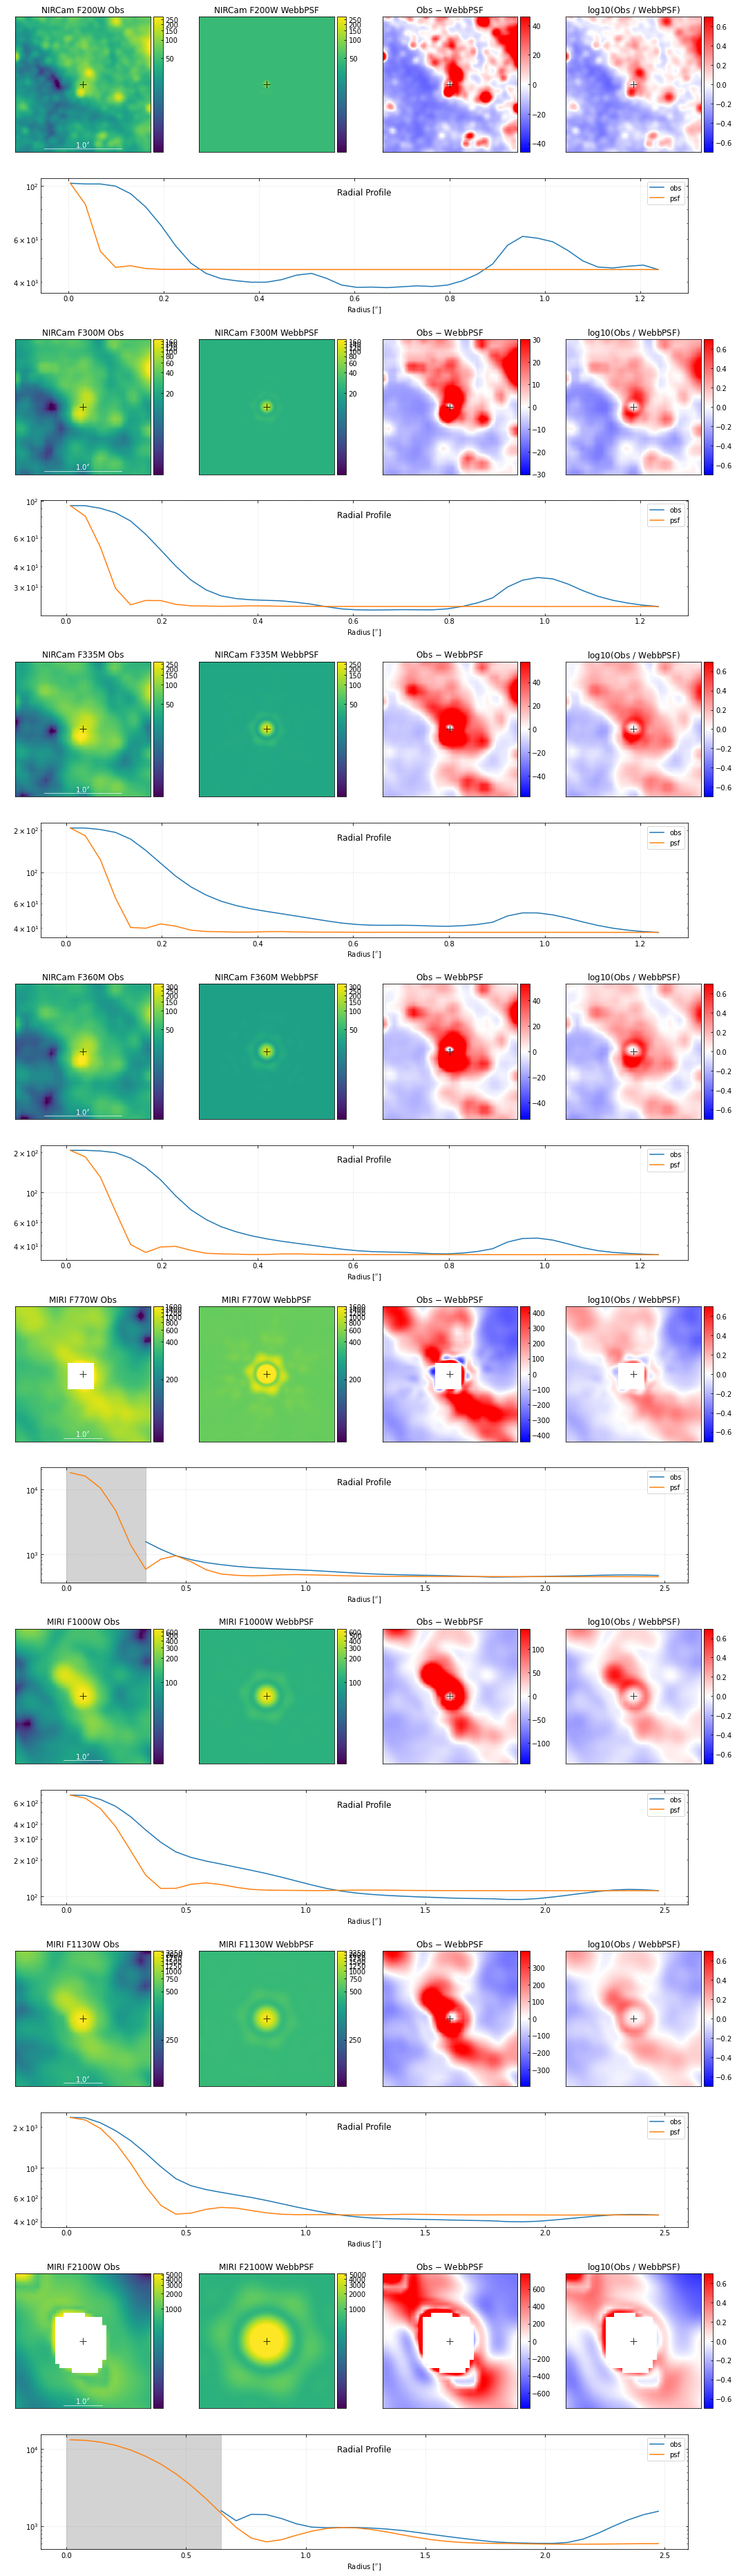

In [13]:
# Main Program - II. make plot

if __name__ == '__main__' and '__file__' not in globals():
    
    fig, axes = plt.subplots(nrows=2*len(sci_images), ncols=4, figsize=(15, 4+3*2*len(sci_images)), 
                             #gridspec_kw=dict(width_ratios=[10,10,10,1]),
                            )

    irow = 0
    
    out_info = OrderedDict()

    for key in sci_images:

        sci_image_resampled = sci_images_resampled[key]
        psf_image_resampled = psf_images_resampled[key]
        pixel_scale = get_pixel_scale(sci_image_resampled)
        cutout_size = cutout_sizes[key]

        sci_image_masked = copy.copy(sci_image_resampled.data)
        psf_image_masked = copy.copy(psf_image_resampled.data)

        sci_image_masked[sci_image_masked==0.0] = np.nan

        # prepare pixel grid arrays
        ny, nx = psf_image_masked.shape
        gy, gx = np.mgrid[0:ny,0:nx]
        gradii = np.sqrt((gx-(nx-1.0)/2.0)**2 + (gy-(ny-1.0)/2.0)**2) * pixel_scale.to(u.arcsec)

        # mask saturated core
        psf_saturatedmask = None
        if key in psf_saturatedmasks:
            psf_saturatedmask = psf_saturatedmasks[key]
        if psf_saturatedmask is not None:
            psf_image_masked[gradii<psf_saturatedmask] = np.nan

        # do radial analysis
        # draw annulli from 0.75 pixel to 0.5 cutout size, in 40 bins
        radii = np.linspace(1.41422*pixel_scale.to(u.arcsec).value, 0.70711*cutout_size.to(u.arcsec).value, num=40) * u.arcsec
        sci_radial_profile = np.full(len(radii), fill_value=np.nan)
        psf_radial_profile = np.full(len(radii), fill_value=np.nan)
        sci_radial_masked = np.full(len(radii), fill_value=np.nan)
        psf_radial_masked = np.full(len(radii), fill_value=np.nan)
        for irad, rad in enumerate(radii):
            radmask = (gradii<rad)
            if irad > 0:
                radmask = np.logical_and(radmask, gradii>=radii[irad-1]) # select an annulus
            if np.count_nonzero(radmask) > 0:
                sci_radial_profile[irad] = np.nanmean(sci_image_resampled.data[radmask])
                psf_radial_profile[irad] = np.nanmean(psf_image_resampled.data[radmask])
                sci_radial_masked[irad] = np.nanmean(sci_image_masked[radmask])
                psf_radial_masked[irad] = np.nanmean(psf_image_masked[radmask])

        # rescale psf image to match the data
        # we will calculate the base and factor so that 'data = psf * factor + base'
        # but first find the saturated core radius
        rescaling_factor = np.nan
        rescaling_base = 0.0
        ratio = sci_radial_masked/psf_radial_masked
        growth = np.concatenate([np.diff(sci_radial_profile), [sci_radial_profile[-1]-sci_radial_profile[-2]]])
        nonsaturated_mask = np.logical_and(ratio>0, growth<=0) # positive growth means increasing with radius
        #print('ratio', ratio)
        #print('growth', growth)
        first_nonsaturated_idx = np.argwhere(nonsaturated_mask).ravel()[0]
        last_nonsaturated_idx = np.argwhere(nonsaturated_mask).ravel()[-1]
        if first_nonsaturated_idx > 0:
            saturated_core = radii[first_nonsaturated_idx]
        else:
            saturated_core = 0.0 * u.arcsec
        print('{} saturated_core: {}'.format(key, saturated_core))
        
        mask = np.logical_and.reduce((nonsaturated_mask, np.isfinite(sci_radial_masked), np.isfinite(psf_radial_masked)))
        if np.count_nonzero(mask) > 0:
            # from scipy.optimize import curve_fit
            # popt, pcov = curve_fit(func_axb, 
            #                  xdata = psf_radial_masked[mask], 
            #                  ydata = sci_radial_masked[mask], 
            #                  #bounds = ([0.0, 0.0], [+np.inf, +np.inf]),
            #                 )
            # print('{} rescaling popt: {}'.format(key, popt))
            # if popt[0] > 0:
            #     rescaling_base = popt[1] # 0.0 # np.nanmin(sci_radial_masked[sci_radial_masked>0])
            #     rescaling_factor = popt[0] # ratio[np.argwhere(mask).ravel()[0]]
            #     print('{} rescaling base: {} (radial profile curve_fit)'.format(key, rescaling_base))
            #     print('{} rescaling factor: {} (radial profile curve_fit)'.format(key, rescaling_factor))
            # else:
            #     rescaling_factor = np.nanmin(ratio[mask]) # ratio[np.argwhere(mask).ravel()[0]]
            #     temp_diff = sci_radial_masked - psf_radial_masked * rescaling_factor
            #     rescaling_base = np.nanmean(np.abs(temp_diff))
            #     temp_ratio = (sci_radial_masked-rescaling_base)/psf_radial_masked
            #     rescaling_factor = temp_ratio[np.argwhere(mask).ravel()[0]]
            #     print('{} rescaling base: {} (radial profile no curve fit)'.format(key, rescaling_base))
            #     print('{} rescaling factor: {} (radial profile no curve fit)'.format(key, rescaling_factor))
            
            # just take the non-saturated
            temp_ratio = (sci_radial_masked-rescaling_base)/psf_radial_masked
            temp_index = np.argwhere(np.logical_and(mask, temp_ratio>0)).ravel()[0]
            rescaling_factor = temp_ratio[temp_index]
            rescaling_base = (sci_radial_masked-psf_radial_masked*rescaling_factor)[last_nonsaturated_idx]
            rescaling_base = max(0.0, rescaling_base) # base cannot be <0
            temp_ratio = (sci_radial_masked-rescaling_base)/psf_radial_masked
            temp_ratio[~nonsaturated_mask] = np.nan
            temp_ratio[temp_ratio<=0.0] = np.nan
            temp_index = np.argwhere(np.logical_and(mask, temp_ratio>0)).ravel()[0]
            rescaling_factor = temp_ratio[temp_index]
            if saturated_core > 0.0:
                temp_ratio[radii>=2.*saturated_core] = np.nan # just trying not to use too far out ratios, empirical
                #print('temp_ratio', temp_ratio)
                rescaling_factor = np.nanmin(temp_ratio)
            #else:
            #    rescaling_factor = np.nanmedian(temp_ratio)
            print('{} rescaling base: {} (radial profile)'.format(key, rescaling_base))
            print('{} rescaling factor: {} (radial profile)'.format(key, rescaling_factor))
        
        if np.isnan(rescaling_factor):
            #rescaling_base = 0.0
            rescaling_factor = np.nanmax(sci_image_masked - rescaling_base)/ np.nanmax(psf_image_masked)
            print('{} rescaling base: {} (image peak)'.format(key, rescaling_base))
            print('{} rescaling factor: {} (image peak)'.format(key, rescaling_factor))

        psf_image_rescaled = psf_image_masked * rescaling_factor + rescaling_base
        psf_radial_rescaled = psf_radial_profile * rescaling_factor + rescaling_base

        #sci_image_masked[gradii<=saturated_core] = np.nan

        # make plot
        make_plot(
            sci_image_masked, 
            psf_image_rescaled, 
            pixel_scale, 
            cutout_size, 
            fig, 
            axes[2*irow], 
            label1 = key + ' Obs',
            label2 = key + ' WebbPSF',
        )

        # also plot radial profiles
        for ax in axes[2*irow+1]:
            ax.remove()
        gs = axes[2*irow+1, 0].get_gridspec()
        axbig = fig.add_subplot(gs[2*irow+1, :])
        axbig.axis('off')
        axradial = axbig.inset_axes([0.05, 0.15, 0.90, 0.85])
        axradial.plot(radii, sci_radial_profile, label='obs')
        axradial.plot(radii, psf_radial_rescaled, label='psf')
        axradial.set_yscale('log')
        axradial.set_xlabel("Radius [$''$]")
        axradial.set_title('Radial Profile', y=0.85, pad=0)
        axradial.grid(True, color='gray', ls='dotted', lw=0.5, alpha=0.5)
        axradial.legend()
        axradial.set_xlim(axradial.get_xlim())
        axradial.set_ylim(axradial.get_ylim())
        if saturated_core.value > 0.0:
            axradial.fill_between([0.0, saturated_core.value], [axradial.get_ylim()[0]]*2, [axradial.get_ylim()[1]]*2,
                                  alpha=0.5, color='darkgray')
        
        # store info into out_info
        out_info[key] = OrderedDict()
        out_info[key]['sci_file'] = sci_files[key]
        out_info[key]['rms_file'] = rms_files[key]
        out_info[key]['psf_file'] = psf_files[key]
        if key in wcs_shifts:
            dRA, dDec = wcs_shifts[key]
            out_info[key]['sci_wcs_shift'] = (dRA.to(u.arcsec).value, dDec.to(u.arcsec).value, 'arcsec')
        else:
            out_info[key]['sci_wcs_shift'] = (0.0, 0.0, 'arcsec')
        out_info[key]['star_skycoord_ra'] = (star_skycoord0.ra.deg, 'deg')
        out_info[key]['star_skycoord_dec'] = (star_skycoord0.dec.deg, 'deg')
        out_info[key]['star_skycoord_frame'] = star_skycoord0.frame.name
        out_info[key]['pixel_scale'] = (pixel_scale.to(u.arcsec).value, 'arcsec')
        out_info[key]['cutout_size'] = (cutout_size.to(u.arcsec).value, 'arcsec')
        out_info[key]['saturated_core'] = (saturated_core.to(u.arcsec).value, 'arcsec')
        out_info[key]['rescaling_base'] = rescaling_base
        out_info[key]['rescaling_factor'] = rescaling_factor

        # next row
        irow += 1

    fig.tight_layout()

    fig.savefig('out_analyzing_ngc1365_miri_psf.pdf')

    out_figure = 'out_analyzing_ngc1365_miri_psf_{:.8f}_{:+.8f}_fk5.pdf'.format(
        star_skycoord0.transform_to(FK5).ra.deg, star_skycoord0.transform_to(FK5).dec.deg)
    if os.path.isfile(out_figure):
        shutil.copy2(out_figure, out_figure+'.backup')
    shutil.copy2('out_analyzing_ngc1365_miri_psf.pdf', out_figure)
    print('Output to {!r}'.format(out_figure))
    
    out_json = re.sub(r'\.pdf$', r'', out_figure) + '.json'
    if os.path.isfile(out_json):
        shutil.copy2(out_json, out_json+'.backup')
    with open(out_json, 'w') as fp:
        json.dump(out_info, fp, indent=4)
    print('Output to {!r}'.format(out_json))
